# **Part 2.1**


1.   Implementation of White Balance algorithms: **Gray World and White Patch** - Equations 3 and 2 from the mentioned below paper were used in this assignment to achieve **basic** Gray World and White Patch color correction respectively [Enhanced Color Correction Using Histogram
Stretching Based On Modified Gray World and
White Patch Algorithms](https://www.ijcsit.com/docs/Volume%205/vol5issue03/ijcsit20140503454.pdf)
2.   Implementation of **Unsharp Masking**
3. White balancing on resulting sharpened images



## White Balance algorithms: Gray World and White Patch
White Balance algorithms allow data scientist achieve more accurate color representation of the digital images.
As per definition: *white balance refers to the adjustment of colors in an image to ensure that white objects appear truly white, regardless of the lighting conditions under which the photo was taken.*

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

Below you can see initial images that were chosen for this assignment.

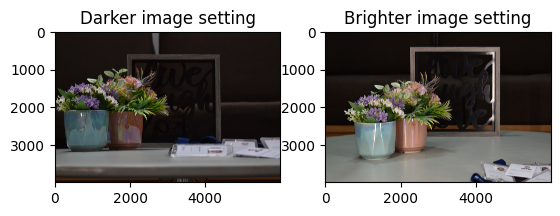

In [114]:
dark_image = imread('../../../images/used_images/light_dark/DSC_0021.JPG')
light_image = imread('../../../images/used_images/light_dark/DSC_0015.JPG')

#plotting both images for further work

images, axarr = plt.subplots(1,2)
axarr[0].imshow(dark_image)
axarr[0].set_title("Darker image setting")
axarr[1].imshow(light_image)
axarr[1].set_title("Brighter image setting")
plt.show()

### **Gray World Algorithm for color correction**
**Assumption:** On average, each photo contains of equal amounts of read, green and blue pixels
**Advantages:** Simple, effective and widely used
**Disadvantage:** May not work well in case of not balanced color distribution

In [115]:
def gray_world_algorithm(img):

  """
  input: image in RGB format (3 channels) [0, 255]

  """

  # for the gray world we need to scale each channel based on illumination
  # estimate and channel mean to normalize values of all three color channels
  # s = avg(avg_R, avg_G, avg_B)/avg_i, where i = {R, G, B}

  
  rgb = np.float32(img) # 0 to 255 -> 0.0 to 255.0
  
  red = rgb[:, :, 0]
  green = rgb[:, :, 1]
  blue = rgb[:, :, 2]

  #let's calculate illumination estimate avg
  avg_R = np.mean(red)
  avg_G = np.mean(green)
  avg_B = np.mean(blue)

  avg = np.divide(sum([avg_R, avg_G, avg_B]), 3)  

  red = np.multiply(red, np.divide(avg, avg_R))  
  green = np.multiply(green, np.divide(avg, avg_G))
  blue = np.multiply(blue, np.divide(avg, avg_B))

  # building modified image
  gray_world_image = np.copy(img)
  gray_world_image[:, :, 0] = np.clip(red, 0, 255)
  gray_world_image[:, :, 1] = np.clip(green, 0, 255)
  gray_world_image[:, :, 2] = np.clip(blue, 0, 255)

  return gray_world_image, [np.divide(avg, avg_R),
                            np.divide(avg, avg_G),
                            np.divide(avg, avg_B)]


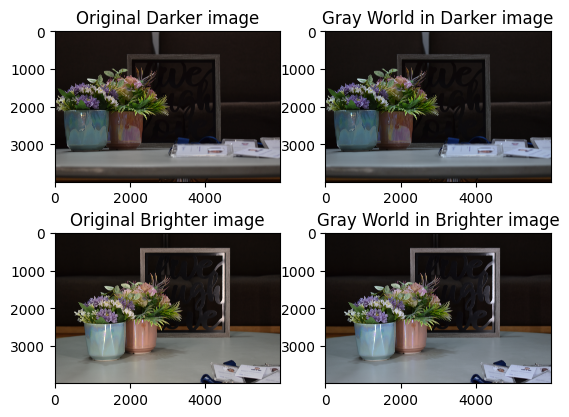

In [116]:
gray_world_dark_image, gray_world_dark_image_scalars = gray_world_algorithm(dark_image)
gray_world_light_image, gray_world_light_image_scalars = gray_world_algorithm(light_image)

#plotting original and modified images

images, axarr = plt.subplots(2,2)
axarr[0, 0].imshow(dark_image)
axarr[0, 0].set_title("Original Darker image")
axarr[0, 1].imshow(gray_world_dark_image)
axarr[0, 1].set_title("Gray World in Darker image")
axarr[1, 0].imshow(light_image)
axarr[1, 0].set_title("Original Brighter image")
axarr[1, 1].imshow(gray_world_light_image)
axarr[1, 1].set_title("Gray World in Brighter image")
plt.show()

In [117]:
print("Average scalar values for RGB in dark image: ", gray_world_dark_image_scalars)
print("Average scalar values for RGB in light image: ", gray_world_light_image_scalars)

Average scalar values for RGB in dark image:  [0.9256712969617575, 1.0071212697443126, 1.079011903785113]
Average scalar values for RGB in light image:  [0.9334023915703574, 0.9922237850354989, 1.0859961937779128]


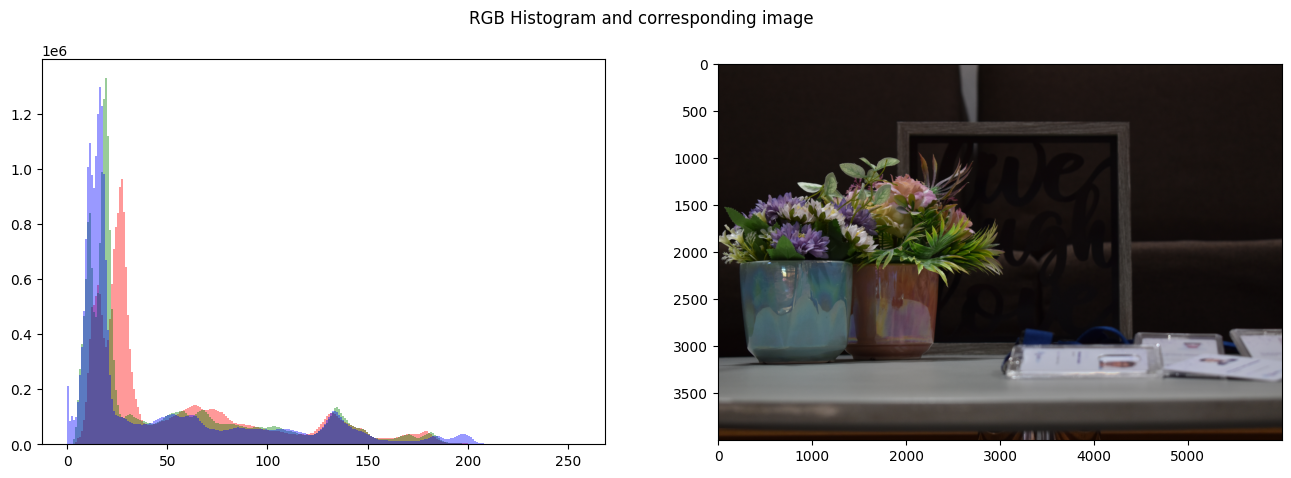

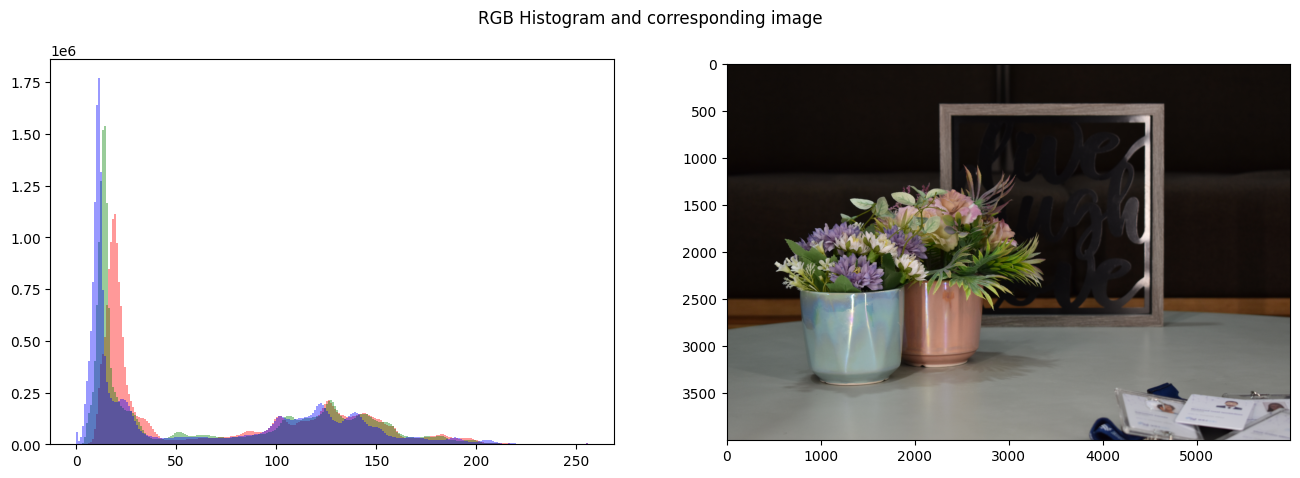

In [118]:
def create_histogram_rgb(img=None):      
    #plotting histogram for all color bands to verify balancing  
    fig, axs = plt.subplots(1, 2)
    fig.suptitle('RGB Histogram and corresponding image')
    fig.set_size_inches(16, 5)

    color = ('red','green','blue')
    for i,col in enumerate(color):            
        axs[0].hist(img[:,:,i].ravel(),256,[0,256], color = col, alpha = 0.4)
           
    axs[1].imshow(img)
    plt.show()
    
create_histogram_rgb(dark_image)
create_histogram_rgb(light_image)    

We can see that in the output, when comparing images before and after color normalization, both pictures don't have a striking difference, although you can observe slight color change for the table (it is now has less of a yellowish tint). After validation, it became obvious that with the Gray World approach and color balance of selected images, value used for scaling would be ~1 (it is because all three color channels seem to be pretty ballanced, which is shown by the histogram above, red looks 'more off' when comparing to the other two, which also correlates with lover average scaling value for it), resulting in images being almost the same. Which actually proves that in "real world scenario" to color correct this particular image we need to use different algorithm. White Patch, for instance.
Before proceeding with it let me show you the impact of a Gray World algorithm on a more vivid example.

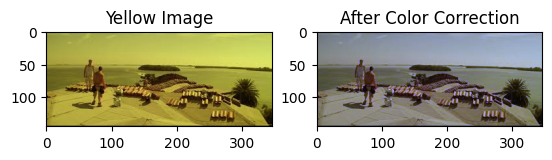

Average scalar values for RGB in yellow image:  [0.7729688410657982, 0.8164569248162279, 2.0769189753207296]


In [119]:
yellow_image = imread('../../../images/used_images/light_dark/images.jpeg')
color_corrected_yellow_image, color_corrected_yellow_image_scalar = gray_world_algorithm(yellow_image)

#plotting yellow image next to it's "Gray World color corrected version"

images, axarr = plt.subplots(1,2)
axarr[0].imshow(yellow_image)
axarr[0].set_title("Yellow Image")
axarr[1].imshow(color_corrected_yellow_image)
axarr[1].set_title("After Color Correction")
plt.show()

#let's output scalars as well to see average difference
print("Average scalar values for RGB in yellow image: ", color_corrected_yellow_image_scalar)


### **White Patch Algorithm for color correction**
**Assumption:** White objects should have the same color intensity in all three color channels
**Advantages:** Simple and easy to implement
**Disadvantage:** Algorithm suffers when there is no or no easily identifiable white or neutral object in the picture

In [120]:
def white_patch_algorithm(img, percentile = 95):
  # We have to stretch each color band that way, so we are able to normalize colors using the one with the highest intensity
  # For this we will use intensity values of each color retrieved with the help of percentile values of each color channel
  # Which will help with avoiding 'white' pixels in order not to make resulting image overly white

  img = img.copy()

  red = img[:, :, 0]
  green = img[:, :, 1]
  blue = img[:, :, 2]

  # Calculation of percentiles for each band
  red_perc = np.percentile(red, percentile)
  green_perc = np.percentile(green, percentile)
  blue_perc = np.percentile(blue, percentile)

  # let's normalize all color bands based on these values
  img = img / [red_perc, green_perc, blue_perc]

  return img.clip(0,1)

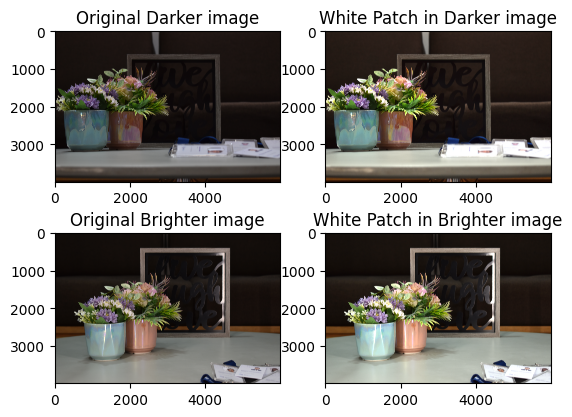

In [121]:
white_patch_dark_image = white_patch_algorithm(dark_image, 97)
white_patch_light_image = white_patch_algorithm(light_image, 98.5)

#plotting original and modified images

images, axarr = plt.subplots(2,2)
axarr[0, 0].imshow(dark_image)
axarr[0, 0].set_title("Original Darker image")
axarr[0, 1].imshow(white_patch_dark_image)
axarr[0, 1].set_title("White Patch in Darker image")
axarr[1, 0].imshow(light_image)
axarr[1, 0].set_title("Original Brighter image")
axarr[1, 1].imshow(white_patch_light_image)
axarr[1, 1].set_title("White Patch in Brighter image")
plt.show()

For this particular set of pictures we can see that "White Patch" algorithm works much better. It stretched all color bands in a way that gradually improved color quality, especially in the darker image set up. To have this freedom of color adjustment it was important to add percentile value, to be able to find the best for both images, which will be different having various near-white spots in second image that impact the final value stretch.

# **Unsharp masking:**
Blurring image using Gaussian/Average smoothing  <br>
Substract the blurred image from the original image (Mask) <br>
Adding the mask to the original image



In [122]:
from skimage import io
from matplotlib import pyplot as plt
import cv2
from PIL import Image
from skimage import io
import numpy as np

PATH1 = '../../../images/used_images/light_dark/DSC_0015.JPG'
PATH2 = '../../../images/used_images/light_dark/DSC_0021.JPG'

img = cv2.imread(PATH1)[:,:,::-1]
img = img.astype(np.float32)
img2 = cv2.imread(PATH2)[:,:,::-1]
img2 = img2.astype(np.float32)

# print (img.max(), img.min())

Note that the image data type was changed to float32 so as to accommodate it with the mathematical operations we are to apply to it, this shall allow us to avoid overflow in image pixel values

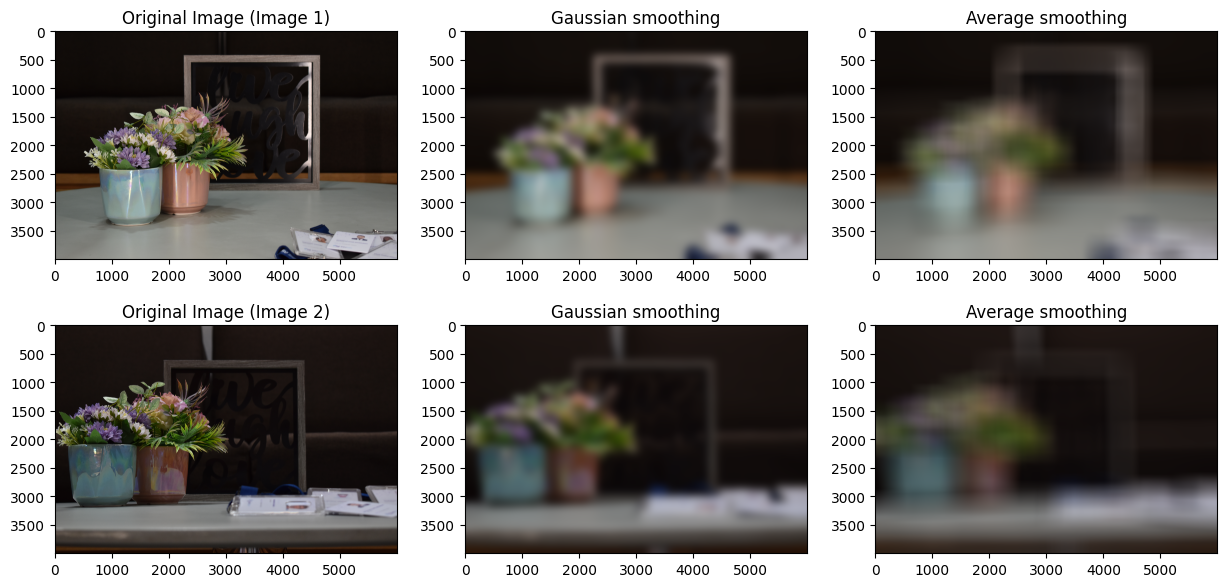

In [123]:
# Applying gaussian blur function provided by OpenCV library (image 1 & 2)
sigma = 0
gau_smoothed = cv2.GaussianBlur(img, (501,501), sigma)
gau_smoothed2 = cv2.GaussianBlur(img2, (501,501), sigma)

# Applying average blur function provided by OpenCV library (image 1 & 2)
avg_smoothed = cv2.blur(img, (501,501))
avg_smoothed2 = cv2.blur(img2, (501,501))

fig, axs = plt.subplots(2, 3,figsize=(15, 7))

# Plot original image
axs[0][0].imshow(np.clip(img, 0, 255).astype(np.uint8))
axs[0][0].set_title("Original Image (Image 1)")

# Plot Gaussian smoothed image
axs[0][1].imshow(np.clip(gau_smoothed, 0, 255).astype(np.uint8))
axs[0][1].set_title("Gaussian smoothing")

# Plot Average smoothed image
axs[0][2].imshow(np.clip(avg_smoothed, 0, 255).astype(np.uint8))
axs[0][2].set_title("Average smoothing")

# Second image:
# Plot original image
axs[1][0].imshow(np.clip(img2, 0, 255).astype(np.uint8))
axs[1][0].set_title("Original Image (Image 2)")

# Plot Gaussian smoothed image
axs[1][1].imshow(np.clip(gau_smoothed2, 0, 255).astype(np.uint8))
axs[1][1].set_title("Gaussian smoothing")

# Plot Average smoothed image
axs[1][2].imshow(np.clip(avg_smoothed2, 0, 255).astype(np.uint8))
axs[1][2].set_title("Average smoothing")

plt.show()


As it is evident from the pictures, gaussian smoothing give better blur results than averaging, hence it is likely to peform better when substracting it with the original for a crispier image. <br>
Note: High kernel window was used for illustrating purpose, and it will be changed for optimum results ("trial and error" approach is used)

**Now we substract the smoothed image (mask) from the original image**

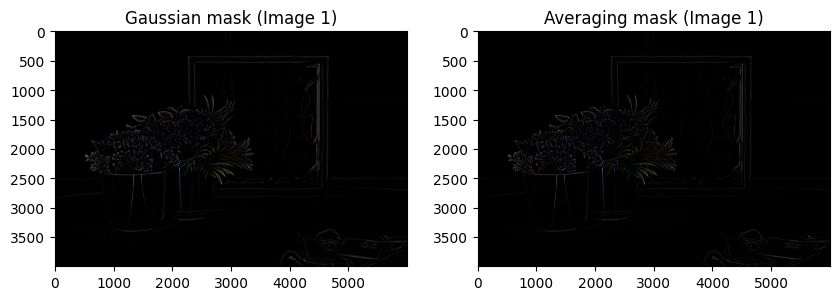

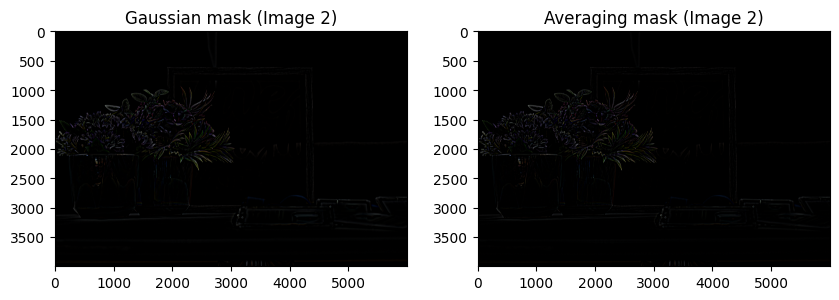

In [124]:
# Now substract the original image from gaussian smoothed image to get the mask (Image 1 & 2)

sigma = 20
gau_smoothed1 = cv2.GaussianBlur(img, (0,0), sigma)
gau_mask1 = cv2.subtract(img, gau_smoothed1)

gau_smoothed2 = cv2.GaussianBlur(img2, (0,0), sigma)
gau_mask2 = cv2.subtract(img2, gau_smoothed2)


avg_smoothed1 = cv2.blur(img, (51,51))
avg_mask1 = cv2.subtract(img, avg_smoothed1)

avg_smoothed2 = cv2.blur(img2, (51,51))
avg_mask2 = cv2.subtract(img2, avg_smoothed2)


# Plotting the mask of average & gaussian smoothing (Image 1 & 2)
fig, axs = plt.subplots(1, 2,figsize=(10, 5))

axs[0].imshow(np.clip(gau_mask1, 0, 255).astype(np.uint8))
axs[0].set_title("Gaussian mask (Image 1)")

axs[1].imshow(np.clip(avg_mask1, 0, 255).astype(np.uint8))
axs[1].set_title("Averaging mask (Image 1)")

fig, axs = plt.subplots(1, 2,figsize=(10, 5))

axs[0].imshow(np.clip(gau_mask2, 0, 255).astype(np.uint8))
axs[0].set_title("Gaussian mask (Image 2)")

axs[1].imshow(np.clip(avg_mask2, 0, 255).astype(np.uint8))
axs[1].set_title("Averaging mask (Image 2)")

plt.show()

We'll be relying on gaussian mask for the next steps since it provides better highlights over the objects

**Here we calculate the unsharped image by adding the mask to the original image**

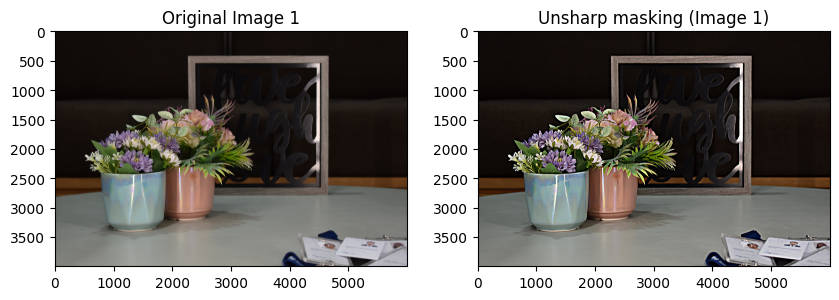

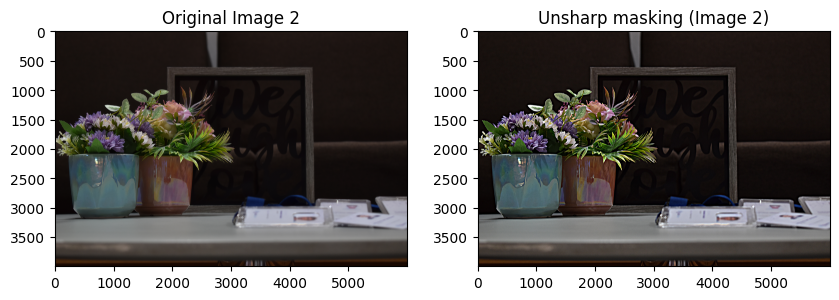

In [125]:
# Applying unsharp masking formula
a = 1
# Image 1
sharp1 = img + (a * gau_mask1)
# Image 2
sharp2 = img2 + (a * gau_mask2)


#print(np.max(sharp2[:,:,2].flatten()))

fig, axs = plt.subplots(1, 2,figsize=(10, 5))
axs[0].imshow(np.clip(img, 0, 255).astype(np.uint8))
axs[0].set_title("Original Image 1")
axs[1].imshow(np.clip(sharp1, 0, 255).astype(np.uint8))
axs[1].set_title("Unsharp masking (Image 1)")

fig, axs = plt.subplots(1, 2,figsize=(10, 5))
axs[0].imshow(np.clip(img2, 0, 255).astype(np.uint8))
axs[0].set_title("Original Image 2")
axs[1].imshow(np.clip(sharp2, 0, 255).astype(np.uint8))
axs[1].set_title("Unsharp masking (Image 2)")

plt.show()

The output of the unsharp masking shows better highlights in the regions where pixel values change dramatically, thus allowing better observation of different color variations and objects within the image. In this example, some flowers appears to be easier to distinguish from the others when observed in the sharped image than the original. In addition, the words written in the woden frame are much sharper and easier to read, especially when applying the highboost filtering as in the next cell.

Let's try greater 'a' value and see how it effects the result (Highboost filtering)

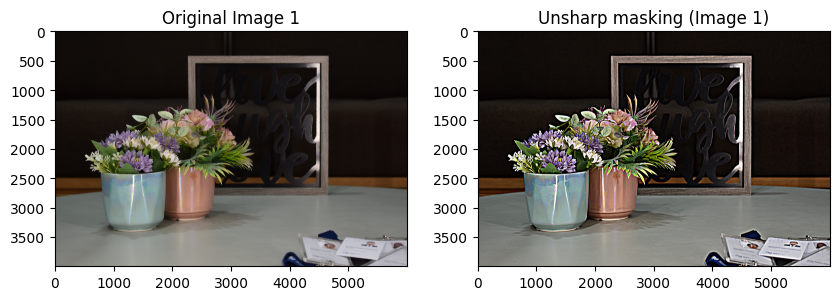

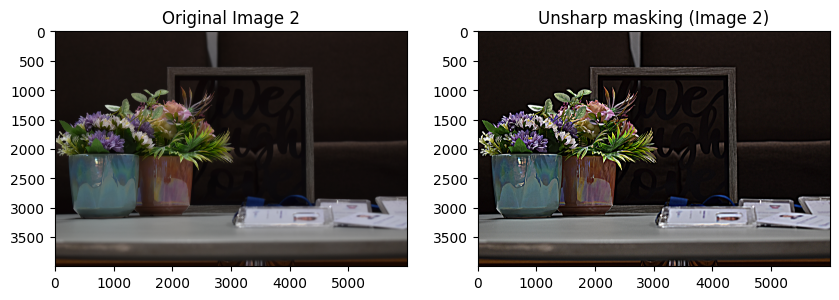

In [126]:
a = 2
# Image 1
sharp1 = img + (a * gau_mask1)
# Image 2
sharp2 = img2 + (a * gau_mask2)


fig, axs = plt.subplots(1, 2,figsize=(10, 5))
axs[0].imshow(np.clip(img, 0, 255).astype(np.uint8))
axs[0].set_title("Original Image 1")
axs[1].imshow(np.clip(sharp1, 0, 255).astype(np.uint8))
axs[1].set_title("Unsharp masking (Image 1)")

fig, axs = plt.subplots(1, 2,figsize=(10, 5))
axs[0].imshow(np.clip(img2, 0, 255).astype(np.uint8))
axs[0].set_title("Original Image 2")
axs[1].imshow(np.clip(sharp2, 0, 255).astype(np.uint8))
axs[1].set_title("Unsharp masking (Image 2)")

plt.show()

## **White balancing on sharpened image**

For this part it was decided to use a=1 output, which basically means that we just straight filter out image using selected Gaussian mask without any further modifications, because it gave us less extra noise when comparing to other values

**Gray world**

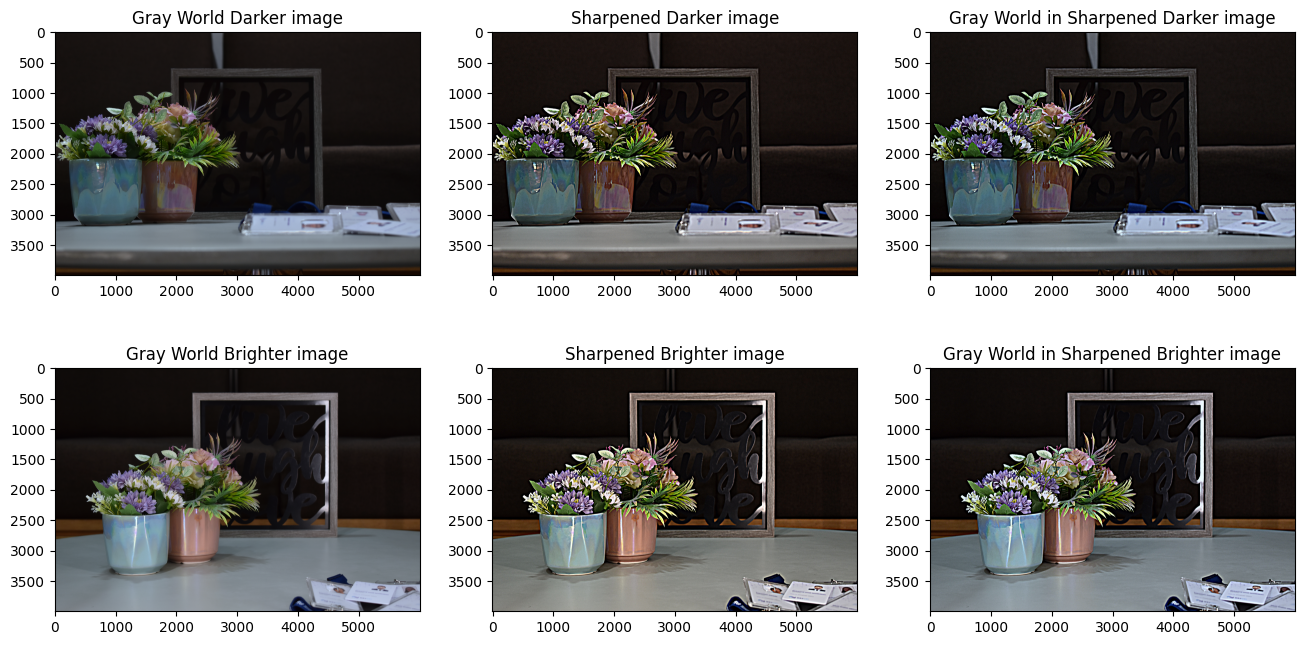

Average scalar values for RGB in sharpened dark image:  [0.9287364592469092, 1.0094804990245665, 1.0722023773689753]
Average scalar values for RGB in sharpened light image:  [0.9354482069677128, 0.9941958114516223, 1.0808991925343565]


In [127]:
gray_world_sharpened_dark_image, gray_world_sharpened_dark_image_scalars = gray_world_algorithm(np.clip(sharp2, 0, 255).astype(np.uint8))
gray_world_sharpened_light_image, gray_world_sharpened_light_image_scalars = gray_world_algorithm(np.clip(sharp1, 0, 255).astype(np.uint8))


#plotting original and modified images

images, axarr = plt.subplots(2,3)
axarr[0, 0].imshow(gray_world_dark_image)
axarr[0, 0].set_title("Gray World Darker image")
axarr[0, 1].imshow(np.clip(sharp2, 0, 255).astype(np.uint8))
axarr[0, 1].set_title("Sharpened Darker image")
axarr[0, 2].imshow(gray_world_sharpened_dark_image)
axarr[0, 2].set_title("Gray World in Sharpened Darker image")
axarr[1, 0].imshow(gray_world_light_image)
axarr[1, 0].set_title("Gray World Brighter image")
axarr[1, 1].imshow(np.clip(sharp1, 0, 255).astype(np.uint8))
axarr[1, 1].set_title("Sharpened Brighter image")
axarr[1, 2].imshow(gray_world_sharpened_light_image)
axarr[1, 2].set_title("Gray World in Sharpened Brighter image")
images.set_size_inches(16, 8)


#plt.savefig('gray_world_sharpened_images.png')


plt.show()

print("Average scalar values for RGB in sharpened dark image: ", gray_world_sharpened_dark_image_scalars)
print("Average scalar values for RGB in sharpened light image: ", gray_world_sharpened_light_image_scalars)

#output_filename = 'Gray_Sharp_dark.jpg'
#cv2.imwrite(output_filename, gray_world_sharpened_light_image[:,:,::-1])
#output_filename = 'Gray_Sharp_light.jpg'
#cv2.imwrite(output_filename, gray_world_sharpened_dark_image[:,:,::-1])




When comparing results between sharpened image and its color corrected version in gray world there is no particular correlation between how these two algorithms impact each other. At the same time it does become obvious that performing these two algorithms together provides better output for further analysis due to the fact that it results in closer true color display and preservation of important edges and color features.

**White patch**

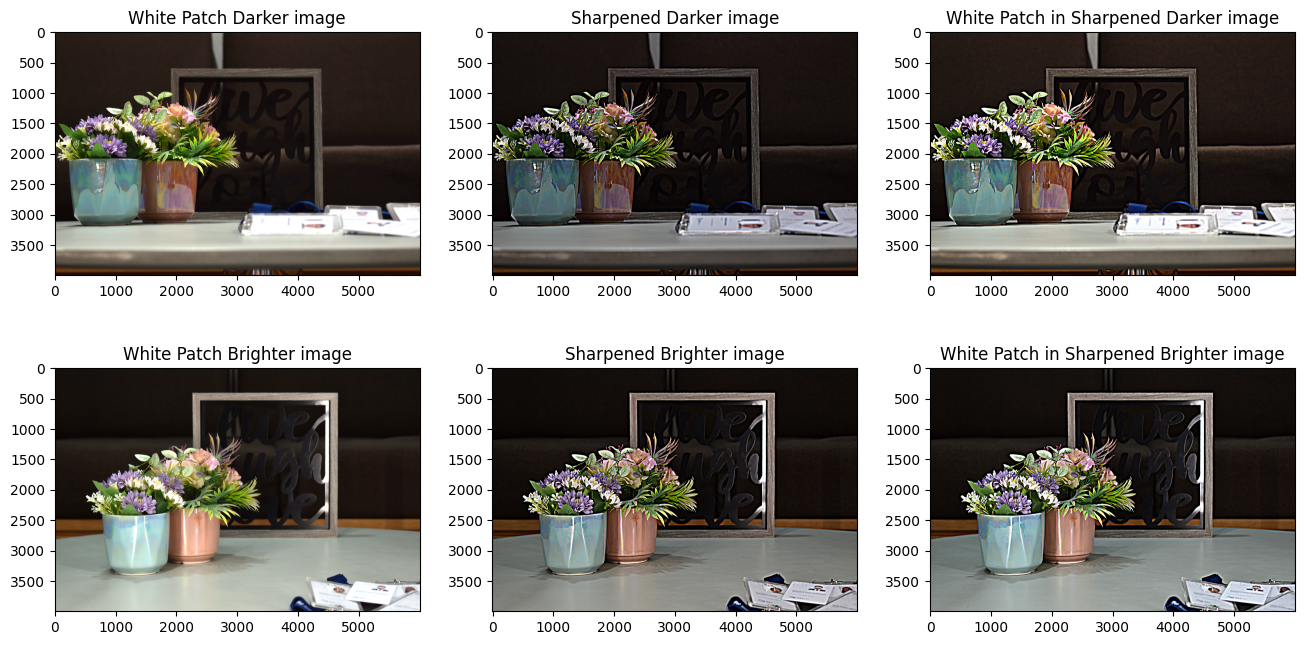

In [128]:
white_patch_sharpened_dark_image = white_patch_algorithm(sharp2, 97)
white_patch_sharpened_light_image = white_patch_algorithm(sharp1, 98.5)

#plotting original and modified images

images, axarr = plt.subplots(2,3)
axarr[0, 0].imshow(white_patch_dark_image)
axarr[0, 0].set_title("White Patch Darker image")
axarr[0, 1].imshow(np.clip(sharp2, 0, 255).astype(np.uint8))
axarr[0, 1].set_title("Sharpened Darker image")
axarr[0, 2].imshow(white_patch_sharpened_dark_image)
axarr[0, 2].set_title("White Patch in Sharpened Darker image")
axarr[1, 0].imshow(white_patch_light_image)
axarr[1, 0].set_title("White Patch Brighter image")
axarr[1, 1].imshow(np.clip(sharp1, 0, 255).astype(np.uint8))
axarr[1, 1].set_title("Sharpened Brighter image")
axarr[1, 2].imshow(white_patch_sharpened_light_image)
axarr[1, 2].set_title("White Patch in Sharpened Brighter image")
images.set_size_inches(16, 8)

plt.show()


The plotted results illustrats how applying white patch resulted in blurring some of edge details, such as how the edge of the badge diffused in the table. Yet, in the sharpenned image this region was preserved to show clear isolation between the two objects. Hence, it's reasonable to consider applying the combination of both as it gives optimum output that provides both color improvement and crispier image.